# All we need is Leak Validation(LV) ?

* **if you like this kernel, please upvote original kernels.**
* update site-4 and site-15

this kernel is still work in progress, but i hope you can find something usefull from this.

In [8]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.metrics import mean_squared_error

In [9]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
%%time
root = Path('../output/ashrae-feather-format-for-fast-loading')

train_df = pd.read_feather(root/'train.feather')
test_df = pd.read_feather(root/'test.feather')
#weather_train_df = pd.read_feather(root/'weather_train.feather')
#weather_test_df = pd.read_feather(root/'weather_test.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

CPU times: user 517 ms, sys: 753 ms, total: 1.27 s
Wall time: 677 ms


In [11]:
# i'm now using my leak data station kernel to shortcut.
# leak_df = pd.read_feather('../input/ashrae-leak-data-station-v8/leak.feather')
leak_df = pd.read_feather('../output/ashrae-leak-data-station/leak.feather')
leak_df.fillna(0, inplace=True)
print (leak_df.timestamp.min(), leak_df.timestamp.max())
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]

2016-01-01 00:00:00 2018-12-31 23:00:00


In [12]:
leak_df.meter.value_counts()

0.0    7512475
1.0    2856222
3.0     963600
2.0     727682
Name: meter, dtype: int64

In [13]:
print (leak_df.duplicated().sum())

0


In [14]:
print (len(leak_df) / len(train_df))

0.5965531927523112


In [15]:
! ls ../input

ashrae-energy-prediction


In [16]:
del train_df
gc.collect()

74

# Leak Validation for public kernels(not used leak data)

In [17]:
# sample_submission1 = pd.read_csv('../input/ashrae-kfold-lightgbm-without-leak-1-08/submission.csv', index_col=0)
# sample_submission2 = pd.read_csv('../input/ashrae-half-and-half/submission.csv', index_col=0)
# sample_submission3 = pd.read_csv('../input/ashrae-highway-kernel-route4/submission.csv', index_col=0)

# sample_submission = pd.read_csv('../input/as-blend-with-2fold-5fold-meter/submission.csv', index_col=1)

# v2版本
sample_submission1 = pd.read_csv('../output/ashrae-kfold-lightgbm-without-leak-1-08/submission.csv', index_col=0)
# sample_submission1 = pd.read_csv('../input/as-other-without-leak-blend/submission.csv', index_col=0)
# sample_submission1 = pd.read_csv('../input/ashrae-kfold-lightgbm-without-leak-xgb-pred/submission.csv', index_col=0)
# sample_submission1 = pd.read_csv('../input/ashrae-kfold-lightgbm-without-leak-d13-pred/submission.csv', index_col=0)
# sample_submission1 = pd.read_csv('../input/ashrae-kfold-lightgbm-without-leak-d14-pred/submission.csv', index_col=0)


# sample_submission2 = pd.read_csv('../input/as-2kfold-model5-0-pred/submission.csv', index_col=1)
# sample_submission2 = pd.read_csv('../input/fork-of-as-2kfold-model6-pred/submission.csv', index_col=1)
# sample_submission2 = pd.read_csv('../input/fork-of-as-2kfold-model6-0-pred/submission.csv', index_col=1)
# sample_submission2 = pd.read_csv('../input/fork-of-as-2kfold-model6-1-pred/submission.csv', index_col=1)
# sample_submission2 = pd.read_csv('../input/fork-of-as-2kfold-model6-xgb-pred/submission.csv', index_col=1)
sample_submission2 = pd.read_csv('../output/fork-of-as-2kfold-model6-xgb-fr7d12-pred/submission.csv', index_col=1)

# sample_submission3 = pd.read_csv('../input/as-meter2-no-1099/submission.csv', index_col=0)
sample_submission3 = pd.read_csv('../output/as-meter2-no-1099-xgb/submission.csv', index_col=0)


# sample_submission4 = pd.read_csv('../input/as-5kfold-model4-no-dt-w-no1099-pred/submission.csv', index_col=1)
# sample_submission4 = pd.read_csv('../input/as-5kfold-model5-no1099-pred/submission.csv', index_col=1)

# sample_submission5 = pd.read_csv('../input/ashrae-simple-data-cleanup-lb-1-08-no-leaks/submission.csv', index_col=0)
# 用的是v10版本
# sample_submission5 = pd.read_csv('../input/ashrae-energy-prediction-using-stratified-kfold/fe2_lgbm.csv', index_col=0)
# sample_submission5 = pd.read_csv('../input/ashrae-divide-and-conquer/submission.csv')
# sample_submission5 = sample_submission5.sort_values('row_id')

gc.collect()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



7

In [18]:
# test_df['pred1'] = sample_submission1.meter_reading
# test_df['pred2'] = sample_submission2.meter_reading
# test_df['pred3'] = sample_submission3.meter_reading

# test_df.loc[test_df.pred3<0, 'pred3'] = 0

# test_df['pred_o'] = sample_submission.meter_reading
# del sample_submission
# gc.collect()


test_df['pred1'] = sample_submission1.meter_reading
del sample_submission1
gc.collect()

test_df['pred2'] = sample_submission2.meter_reading
del sample_submission2
gc.collect()

test_df['pred3'] = sample_submission3.meter_reading
del sample_submission3
gc.collect()

# test_df['pred4'] = sample_submission4.meter_reading
# del sample_submission4
# gc.collect()


# # test_df['pred5'] = sample_submission5.meter_reading
# test_df['pred5'] = sample_submission5.meter_reading.values
# del sample_submission5
# gc.collect()


# del  sample_submission1,  sample_submission2,  sample_submission3
# del sample_submission, sample_submission1,  sample_submission2,  sample_submission3
# gc.collect()

# test_df = reduce_mem_usage(test_df)
# leak_df = reduce_mem_usage(leak_df)

14

In [19]:
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'pred1', 'pred2', 'pred3', 'row_id']], left_on = ['building_id', 'meter', 'timestamp'], right_on = ['building_id', 'meter', 'timestamp'], how = "left")
leak_df = leak_df.merge(building_meta_df[['building_id', 'site_id']], on='building_id', how='left')

In [20]:
# leak_df['pred_o_l1p'] = np.log1p(leak_df.pred_o)

leak_df['pred1_l1p'] = np.log1p(leak_df.pred1)
leak_df['pred2_l1p'] = np.log1p(leak_df.pred2)
leak_df['pred3_l1p'] = np.log1p(leak_df.pred3)
# leak_df['pred4_l1p'] = np.log1p(leak_df.pred4)

# leak_df['pred5_l1p'] = np.log1p(leak_df.pred5)

leak_df['meter_reading_l1p'] = np.log1p(leak_df.meter_reading)
gc.collect()

84

In [21]:
leak_df.head()

,building_id,meter,meter_reading,timestamp,pred1,pred2,pred3,row_id,site_id,pred1_l1p,pred2_l1p,pred3_l1p,meter_reading_l1p
0,0,0.0,173.370293,2017-01-01,186.168107,144.790047,169.0462,0,0,5.232007,4.982168,5.136070,5.161181
1,1,0.0,53.512720,2017-01-01,85.102571,69.022503,71.9008,1,0,4.455539,4.248817,4.289100,3.998434
2,2,0.0,6.143042,2017-01-01,13.020658,7.801228,7.5950,2,0,2.640532,2.174891,2.151181,1.966139
3,3,0.0,101.701470,2017-01-01,249.669041,249.000580,298.2076,3,0,5.524134,5.521463,5.701138,4.631826
4,4,0.0,1141.240666,2017-01-01,1130.942372,1180.897888,1354.3573,4,0,7.031690,7.074877,7.211820,7.040747


In [22]:
leak_df[leak_df.pred1_l1p.isnull()]

,building_id,meter,meter_reading,timestamp,pred1,pred2,pred3,row_id,site_id,pred1_l1p,pred2_l1p,pred3_l1p,meter_reading_l1p


In [23]:
# #上一次blend
# sns.distplot(leak_df.pred_o_l1p)
# sns.distplot(leak_df.meter_reading_l1p)

# leak_score = np.sqrt(mean_squared_error(leak_df.pred_o_l1p, leak_df.meter_reading_l1p))
# print ('score1=', leak_score)

score1= 0.9855484904516869


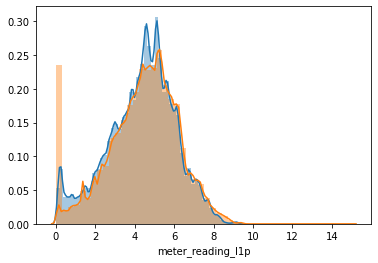

In [24]:
#ashrae-kfold-lightgbm-without-leak-1-08
sns.distplot(leak_df.pred1_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred1_l1p, leak_df.meter_reading_l1p))
print ('score1=', leak_score)

score2= 0.971224777982656


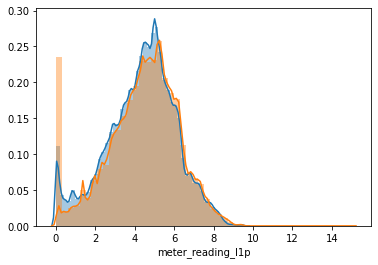

In [25]:
#2折1.08
sns.distplot(leak_df.pred2_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred2_l1p, leak_df.meter_reading_l1p))
print ('score2=', leak_score)

score3= 0.9528127138774507


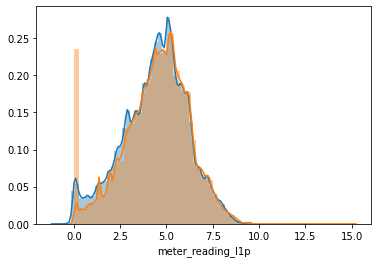

In [26]:
# meter split based 1.07
sns.distplot(leak_df.pred3_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred3_l1p, leak_df.meter_reading_l1p))
print ('score3=', leak_score)

In [27]:
# ashrae-kfold-lightgbm-without-leak-1-08 looks best

# Leak Validation for Blending

A one idea how we can use LV usefull is blending. We probably can find best blending method without LB probing and it's means we can save our submission.

In [28]:
# leak_df['mean_pred'] = np.mean(leak_df[['pred1', 'pred2', 'pred3']].values, axis=1)
# leak_df['mean_pred_l1p'] = np.log1p(leak_df.mean_pred)
# leak_score = np.sqrt(mean_squared_error(leak_df.mean_pred_l1p, leak_df.meter_reading_l1p))


# sns.distplot(leak_df.mean_pred_l1p)
# sns.distplot(leak_df.meter_reading_l1p)

# print ('mean score=', leak_score)

In [29]:
# leak_df['median_pred'] = np.median(leak_df[['pred1', 'pred2', 'pred3']].values, axis=1)
# leak_df['median_pred_l1p'] = np.log1p(leak_df.median_pred)
# leak_score = np.sqrt(mean_squared_error(leak_df.median_pred_l1p, leak_df.meter_reading_l1p))

# sns.distplot(leak_df.median_pred_l1p)
# sns.distplot(leak_df.meter_reading_l1p)

# print ('meadian score=', leak_score)

Ummm... it looks mean blending is beter than median blending

In [30]:
# # 上一次的比例, 按原始比例,验证分数降低
# leak_df['blend_pred'] = (0.21 * leak_df.pred2 + 0.28 * leak_df.pred3 + 0.27 * leak_df.pred4 + leak_df.pred_o) / 1.76
# leak_df['blend_pred_l1p'] = np.log1p(leak_df.blend_pred)
# leak_score = np.sqrt(mean_squared_error(leak_df.blend_pred_l1p, leak_df.meter_reading_l1p))


# sns.distplot(leak_df.blend_pred_l1p)
# sns.distplot(leak_df.meter_reading_l1p)

# print ('mean score=', leak_score)

In [31]:
# # 上一次的比例, 按原始比例,验证分数降低
# leak_df['blend_pred'] = 0.25 * leak_df.pred1 + 0.25 * leak_df.pred2 + 0.25 * leak_df.pred3 + 0.25 * leak_df.pred4
# leak_df['blend_pred_l1p'] = np.log1p(leak_df.blend_pred)
# leak_score = np.sqrt(mean_squared_error(leak_df.blend_pred_l1p, leak_df.meter_reading_l1p))


# sns.distplot(leak_df.blend_pred_l1p)
# sns.distplot(leak_df.meter_reading_l1p)

# print ('mean score=', leak_score)

In [32]:
# # 上一次的比例, 按原始比例,验证分数降低
# leak_df['blend_pred'] = 0.35 * leak_df.pred1 + 0.15 * leak_df.pred2 + 0.45 * leak_df.pred3 + 0.05 * leak_df.pred4
# leak_df['blend_pred_l1p'] = np.log1p(leak_df.blend_pred)
# leak_score = np.sqrt(mean_squared_error(leak_df.blend_pred_l1p, leak_df.meter_reading_l1p))


# sns.distplot(leak_df.blend_pred_l1p)
# sns.distplot(leak_df.meter_reading_l1p)

# print ('mean score=', leak_score)

In [33]:
test_df[['pred1', 'pred2', 'pred3']].corr()

,pred1,pred2,pred3
pred1,1.000000,0.959267,0.927487
pred2,0.959267,1.000000,0.919599
pred3,0.927487,0.919599,1.000000


In [34]:
# # 上一次的比例, 按原始比例,验证分数降低
# leak_df['blend_pred'] = 0.4 * leak_df.pred1 + 0.15 * leak_df.pred2 + 0.4 * leak_df.pred3 + 0.05 * leak_df.pred4
# leak_df['blend_pred_l1p'] = np.log1p(leak_df.blend_pred)
# leak_score = np.sqrt(mean_squared_error(leak_df.blend_pred_l1p, leak_df.meter_reading_l1p))


# sns.distplot(leak_df.blend_pred_l1p)
# sns.distplot(leak_df.meter_reading_l1p)

# print ('mean score=', leak_score)

mean score= 0.9498280225033974


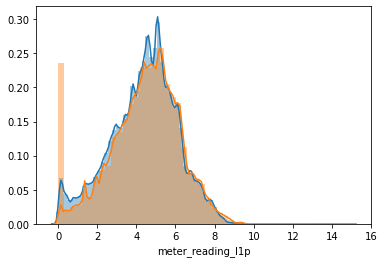

In [35]:
# 上一次的比例, 按原始比例,验证分数降低
leak_df['blend_pred'] = 0.45 * leak_df.pred1 + 0.25 * leak_df.pred2 + 0.3 * leak_df.pred3
leak_df['blend_pred_l1p'] = np.log1p(leak_df.blend_pred)
leak_score = np.sqrt(mean_squared_error(leak_df.blend_pred_l1p, leak_df.meter_reading_l1p))


sns.distplot(leak_df.blend_pred_l1p)
sns.distplot(leak_df.meter_reading_l1p)

print ('mean score=', leak_score)

In [36]:
# # 上一次的比例, 按原始比例,验证分数降低
# leak_df['blend_pred'] = 0.3 * leak_df.pred1 + 0.05 * leak_df.pred2 + 0.65 * leak_df.pred3 + 0.00 * leak_df.pred4
# leak_df['blend_pred_l1p'] = np.log1p(leak_df.blend_pred)
# leak_score = np.sqrt(mean_squared_error(leak_df.blend_pred_l1p, leak_df.meter_reading_l1p))


# sns.distplot(leak_df.blend_pred_l1p)
# sns.distplot(leak_df.meter_reading_l1p)

# print ('mean score=', leak_score)

In [37]:
# # 上一次的比例, 按原始比例,验证分数降低
# leak_df['blend_pred'] = (0.3 * leak_df.pred1 + 0.05 * leak_df.pred2 + 0.65 * leak_df.pred3 + 0.00 * leak_df.pred4) * 0.9
# leak_df['blend_pred_l1p'] = np.log1p(leak_df.blend_pred)
# leak_score = np.sqrt(mean_squared_error(leak_df.blend_pred_l1p, leak_df.meter_reading_l1p))


# sns.distplot(leak_df.blend_pred_l1p)
# sns.distplot(leak_df.meter_reading_l1p)

# print ('mean score=', leak_score)

mean score= 0.9454484616338069


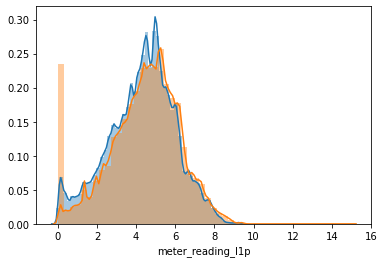

In [38]:
# 上一次的比例, 按原始比例,验证分数降低
leak_df['blend_pred'] = (0.45 * leak_df.pred1 + 0.25 * leak_df.pred2 + 0.3 * leak_df.pred3) * 0.91
leak_df['blend_pred_l1p'] = np.log1p(leak_df.blend_pred)
leak_score = np.sqrt(mean_squared_error(leak_df.blend_pred_l1p, leak_df.meter_reading_l1p))


sns.distplot(leak_df.blend_pred_l1p)
sns.distplot(leak_df.meter_reading_l1p)

print ('mean score=', leak_score)

In [39]:
# import matplotlib.pyplot as plt

In [40]:
# plt.figure(figsize=(6, 6))
# plt.scatter(leak_df.meter_reading_l1p, np.log1p(0.45 * leak_df.pred1 + 0.25 * leak_df.pred2 + 0.3 * leak_df.pred3))
# # plt.plot(range(10, 15), range(10, 15), color="red")

In [41]:
# # 上一次的比例, 按原始比例,验证分数降低
# leak_df['blend_pred'] = 0.15 * leak_df.pred1 + 0.2 * leak_df.pred2 + 0.3 * leak_df.pred3 + 0.00 * leak_df.pred4 + 0.35 * leak_df.pred5
# leak_df['blend_pred_l1p'] = np.log1p(leak_df.blend_pred)
# leak_score = np.sqrt(mean_squared_error(leak_df.blend_pred_l1p, leak_df.meter_reading_l1p))


# sns.distplot(leak_df.blend_pred_l1p)
# sns.distplot(leak_df.meter_reading_l1p)

# print ('mean score=', leak_score)

In [42]:
# # 上一次的比例, 按原始比例,验证分数降低
# leak_df['blend_pred'] = (0.15 * leak_df.pred1 + 0.2 * leak_df.pred2 + 0.3 * leak_df.pred3 + 0.00 * leak_df.pred4 + 0.35 * leak_df.pred5) * 0.91
# leak_df['blend_pred_l1p'] = np.log1p(leak_df.blend_pred)
# leak_score = np.sqrt(mean_squared_error(leak_df.blend_pred_l1p, leak_df.meter_reading_l1p))


# sns.distplot(leak_df.blend_pred_l1p)
# sns.distplot(leak_df.meter_reading_l1p)

# print ('mean score=', leak_score)

In [43]:
# # 上一次的比例, 按原始比例,验证分数降低
# leak_df['blend_pred'] = 0.2 * leak_df.pred1 + 0.2 * leak_df.pred2 + 0.2 * leak_df.pred3 + 0.2 * leak_df.pred4 + 0.2 * leak_df.pred5
# leak_df['blend_pred_l1p'] = np.log1p(leak_df.blend_pred)
# leak_score = np.sqrt(mean_squared_error(leak_df.blend_pred_l1p, leak_df.meter_reading_l1p))


# sns.distplot(leak_df.blend_pred_l1p)
# sns.distplot(leak_df.meter_reading_l1p)

# print ('mean score=', leak_score)

# Find Best Weight

In [44]:
# N = 10
# scores = np.zeros(N,)
# for i in range(N):
#     p = i * 1./N
#     v = p * leak_df['pred1'].values + (1.-p) * leak_df ['pred3'].values
#     vl1p = np.log1p(v)
#     scores[i] = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))

In [45]:
# plt.plot(scores)

In [46]:
# best_weight = np.argmin(scores) *  1./N
# print (scores.min(), best_weight)

In [47]:
# # and more
# scores = np.zeros(N,)
# for i in range(N):
#     p = i * 1./N
#     v =  p * (best_weight * leak_df['pred1'].values + (1.-best_weight) * leak_df ['pred3'].values) + (1.-p) * leak_df ['pred2'].values
#     vl1p = np.log1p(v)
#     scores[i] = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))

In [48]:
# plt.plot(scores)

In [49]:
# best_weight2 = np.argmin(scores) *  1./N
# print (scores.min(), best_weight2)
# # its seams better than simple mean 0.92079717

# Heuristic way

In [50]:
# v = 0.33 * leak_df['pred1'].values + 0.33 * leak_df['pred3'].values + 0.3 * leak_df['pred2'].values
# vl1p = np.log1p(v)

# print (np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p)))

# Submit

In [51]:
# sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
# sample_submission['meter_reading'] = 0.27 * test_df.pred1 + 0.2 * test_df.pred2 + 0.27 * test_df.pred3 + 0.26 * test_df.pred4
# sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0


# sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
# sample_submission['meter_reading'] = (0.21 * test_df.pred2 + 0.28 * test_df.pred3 + 0.27 * test_df.pred4 + test_df.pred_o) / 1.76
# sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0


# sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
# sample_submission['meter_reading'] = 0.25 * test_df.pred1 + 0.25 * test_df.pred2 + 0.25 * test_df.pred3 + 0.25 * test_df.pred4
# sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0


# sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
# sample_submission['meter_reading'] = 0.2 * test_df.pred1 + 0.2 * test_df.pred2 + 0.2 * test_df.pred3 + 0.2 * test_df.pred4 + 0.2 * test_df.pred5
# sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0


# sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
# sample_submission['meter_reading'] = 0.35 * test_df.pred1 + 0.15 * test_df.pred2 + 0.45 * test_df.pred3 + 0.05 * test_df.pred4
# sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0


# sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
# sample_submission['meter_reading'] = 0.4 * test_df.pred1 + 0.15 * test_df.pred2 + 0.4 * test_df.pred3 + 0.05 * test_df.pred4
# sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0


# sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
# sample_submission['meter_reading'] = 0.45 * test_df.pred1 + 0.25 * test_df.pred2 + 0.3 * test_df.pred3
# sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0



sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
sample_submission['meter_reading'] = (0.45 * test_df.pred1 + 0.25 * test_df.pred2 + 0.3 * test_df.pred3) * 0.9
sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0


# sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
# sample_submission['meter_reading'] = (0.15 * test_df.pred1 + 0.2 * test_df.pred2 + 0.3 * test_df.pred3 + 0.35 * test_df.pred5) * 0.91
# sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0


# sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
# sample_submission['meter_reading'] = (0.3 * test_df.pred1 + 0.05 * test_df.pred2 + 0.65 * test_df.pred3) * 0.9
# sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

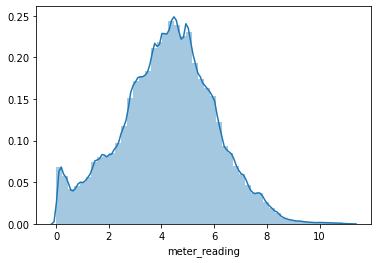

In [52]:
sns.distplot(np.log1p(sample_submission.meter_reading))

In [53]:
leak_df = leak_df[['meter_reading', 'row_id']].set_index('row_id').dropna()
sample_submission.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']

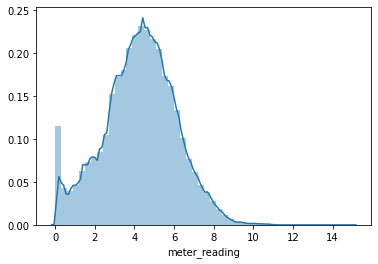

In [54]:
sns.distplot(np.log1p(sample_submission.meter_reading))

In [55]:
sample_submission

,row_id,meter_reading
0,0,173.370293
1,1,53.512720
2,2,6.143042
3,3,101.701470
4,4,1141.240666
5,5,13.651204
6,6,260.874513
7,7,502.705590
8,8,717.574038
9,9,513.285268


In [56]:
sample_submission.head()

,row_id,meter_reading
0,0,173.370293
1,1,53.512720
2,2,6.143042
3,3,101.701470
4,4,1141.240666


In [58]:
sample_submission.to_csv('../output/as-leakage-replace-new/submission.csv', index=False, float_format='%.4f')